In [1]:
import os

import numpy as np
import torch
from pyro.contrib.examples.util import MNIST
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.utils as vutils
import visdom
import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from made import MADE
from gmade import GMADE
import matplotlib.pyplot as plt 
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = MNIST(root=root, train=True, transform=trans,
                      download=download)
    test_set = MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img

class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        # then compute the hidden units
        #hidden = self.softplus(self.fc1(x))
        hidden = nn.functional.relu(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        #z_scale = torch.exp(self.fc22(hidden))
        z_scale = self.softplus(self.fc22(hidden))
        
        return z_loc, z_scale
    
class MyEncoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        self.z_dim = z_dim
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim * 2)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        # then compute the hidden units
        #hidden = self.softplus(self.fc1(x))
        hidden = nn.functional.relu(self.fc1(x))
        out = self.fc21(hidden)
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = torch.narrow(out, -1, 0, self.z_dim)
        
        z_scale = self.softplus(torch.narrow(out, -1, self.z_dim, self.z_dim))
        #print(out.shape, z_loc.shape, z_scale.shape)
        #z_scale = torch.exp(self.fc22(hidden))
        #z_scale = self.softplus(self.fc22(hidden))
        
        return z_loc, z_scale

class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        #self.encoder = Encoder(z_dim, hidden_dim)
        self.encoder = MyEncoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)
        self.xprob = None
        self.softplus = nn.Softplus()
        
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        
        input_dim_dict = {
            "x" : 784,
        }
        var_dim_dict = {
            "z" : z_dim,
        }
        
        dependency_dict = {
            "z" : ["x"]
        }
        
        to_event_dict = {
            "z" : 1
        }
        
        hidden_sizes = [[hidden_dim]]
        
        self.gmade = GMADE(input_dim_dict, dependency_dict, var_dim_dict, to_event_dict=to_event_dict, hidden_sizes=hidden_sizes, use_cuda=use_cuda, verbose=False)
        
        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
            
    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder(z)
            
             # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))
            return loc_img

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            #print(x.shape)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
    
    # define the guide (i.e. variational distribution) q(z|x)
    def guide_gmade(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.gmade)
        x = x.reshape(-1, 784)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            #print(x.shape)
            input_gmade = {
                "x" : x
            }
            self.gmade(input_gmade, suffix="")

    def guide_gmade2(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.gmade)
        x = x.reshape(-1, 784)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)

            out = self.gmade.levels[0](x)
            z_loc = torch.narrow(out, -1, 0, self.z_dim)
            z_scale = self.softplus(torch.narrow(out, -1, self.z_dim, self.z_dim))
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        print(x.shape)
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        print(z.shape)
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img
    def reconstruct_img_gmade(self, x):
        # encode image x
        print(x.shape)
        input_gmade = {
                "x" : x.reshape(-1, 784)
        }
        self.gmade.eval()
        out_dict = self.gmade(input_gmade, suffix="")
        
        # sample in latent space
        z = out_dict["z"]
        print(z.shape)
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        self.gmade.train()
        return loc_img

[epoch 000]  average training loss: 186.9631


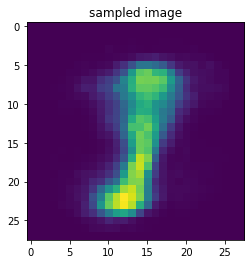

torch.Size([1, 28, 28])
haha
torch.Size([1, 50])


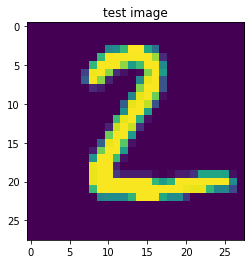

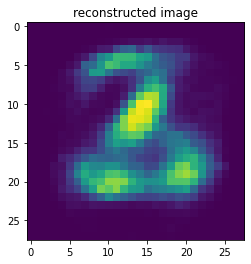

torch.Size([1, 28, 28])
haha
torch.Size([1, 50])


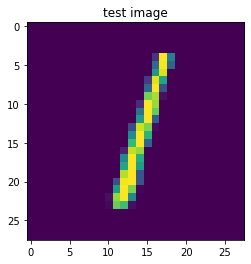

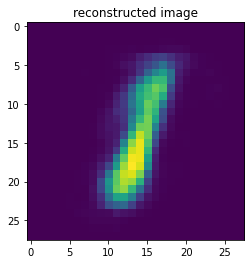

torch.Size([1, 28, 28])
haha
torch.Size([1, 50])


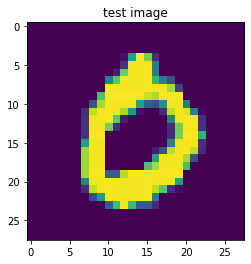

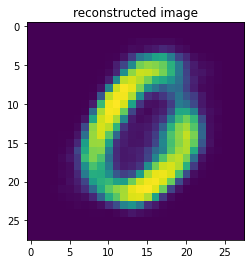

[epoch 000] average test loss: 153.1490
[epoch 001]  average training loss: 143.5495
[epoch 002]  average training loss: 130.7110
[epoch 003]  average training loss: 123.2441
[epoch 004]  average training loss: 118.5312
[epoch 005]  average training loss: 115.3581


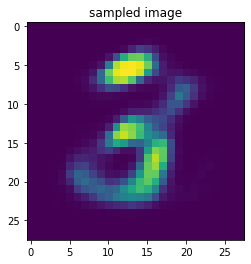

torch.Size([1, 28, 28])
haha
torch.Size([1, 50])


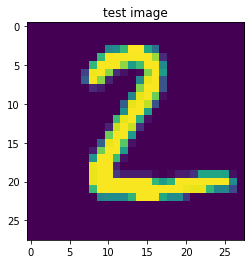

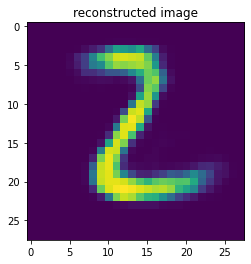

torch.Size([1, 28, 28])
haha
torch.Size([1, 50])


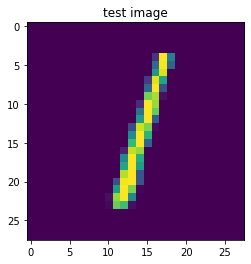

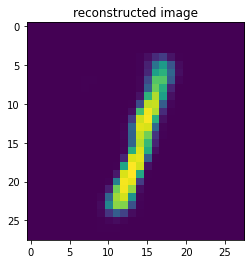

torch.Size([1, 28, 28])
haha
torch.Size([1, 50])


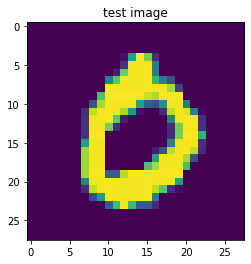

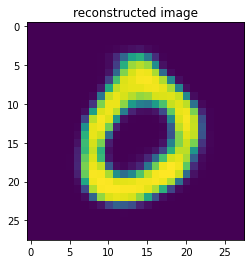

[epoch 005] average test loss: 113.1526
[epoch 006]  average training loss: 113.1392
[epoch 007]  average training loss: 111.6889


In [ ]:
# vae = VAE()
#optimizer = Adam({"lr": 1.0e-3})
#svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

def plot_vae_sample(vae, use_cuda):
    
    x = torch.zeros([1, 784])
    if use_cuda:
            x = x.cuda()
            
    sample_loc_i = vae.model(x)
    img = sample_loc_i[0].view(28, 28).detach().cpu().numpy()
    plt.imshow(img)
    plt.title("sampled image")
    plt.show()
    
        
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for i, (x, _) in enumerate(test_loader):
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
        if i == 0:
                    plot_vae_sample(vae, use_cuda)
                    reco_indices = np.random.randint(0, x.shape[0], 3)
                    reco_indices = [1, 2, 3]
                    for index in reco_indices:
                        test_img = x[index, :]
                        #reco_img = vae.reconstruct_img(test_img)
                        reco_img = vae.reconstruct_img_gmade(test_img)
                        
                        plt.imshow(test_img.reshape(28, 28).detach().cpu().numpy())
                        plt.title("test image")
                        plt.show()
                        
                        plt.imshow(reco_img.reshape(28, 28).detach().cpu().numpy())
                        plt.title("reconstructed image")
                        plt.show()
                            
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

#vis = visdom.Visdom()
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = True

# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 100
TEST_FREQUENCY = 5
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide_gmade2, optimizer, loss=Trace_ELBO())
#guide_gmade
train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

In [ ]:
# [epoch 085] average test loss: 101.5442
# [epoch 086]  average training loss: 101.3335
# [epoch 087]  average training loss: 101.2922
# [epoch 088]  average training loss: 101.2392
# [epoch 089]  average training loss: 101.2492
# [epoch 090]  average training loss: 101.2153
# [epoch 090] average test loss: 101.3788
# [epoch 091]  average training loss: 101.1905
# [epoch 092]  average training loss: 101.1558
# [epoch 093]  average training loss: 101.0930
# [epoch 094]  average training loss: 101.0869
# [epoch 095]  average training loss: 101.1088
# [epoch 095] average test loss: 101.5306
# [epoch 096]  average training loss: 101.0934
# [epoch 097]  average training loss: 101.0356
# [epoch 098]  average training loss: 101.0283
# [epoch 099]  average training loss: 101.0030